In [ ]:
!pip install -q tensorflow-recommenders
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 5.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
import re

tfidf = TfidfVectorizer(max_features=5000)
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

In [ ]:
tourism_rating = pd.read_csv('tourism_rating.csv')
tourism_with_id = pd.read_csv('tourism_with_id.csv')
users = pd.read_csv('user.csv')
print(tourism_with_id.info())
print(tourism_rating.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         -------------

In [ ]:
#Drop Column
tourism_with_id.drop(['Time_Minutes','Coordinate','Lat','Long','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)

# Detect Missing Value
print("==========  Missing Values ==========")
print(tourism_rating.isna().sum())
print(tourism_with_id.isna().sum())

# handlimg missing value
tourism_rating["User_Id"] = tourism_rating["User_Id"].fillna(0)
tourism_rating["Place_Id"] = tourism_rating["Place_Id"].fillna(0)
tourism_rating["Place_Ratings"] = tourism_rating["Place_Ratings"].fillna(0)

print(tourism_rating.isna().sum())

print(tourism_with_id.info())
print(tourism_rating.info())

==========  Missing Values ==========
User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64
Place_Id       0
Place_Name     0
Description    0
Category       0
City           0
Price          0
Rating         0
dtype: int64
User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place_Id     437 non-null    int64  
 1   Place_Name   437 non-null    object 
 2   Description  437 non-null    object 
 3   Category     437 non-null    object 
 4   City         437 non-null    object 
 5   Price        437 non-null    int64  
 6   Rating       437 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 24.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Coun

In [ ]:
all_tourism = pd.merge(tourism_rating.groupby('Place_Id')['Place_Ratings'].mean(),tourism_with_id,on='Place_Id')
all_tourism.head()

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating
0,1,3.722222,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6
1,2,2.840000,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6
2,3,2.526316,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6
3,4,2.857143,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5
4,5,3.520000,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5


In [ ]:
def preprocessing(data):
    data = data.lower()
    data = stem.stem(data)
    data = stopword.remove(data)
    html_pattern = re.compile('<.*?>')
    data = html_pattern.sub(r'', data)
    tokenizer = RegexpTokenizer(r'\w+')
    data_token = tokenizer.tokenize(data)
    data = " ".join(data_token)
    return data

In [ ]:
data_filtering = all_tourism.copy()
data_filtering['Content'] = data_filtering['Description'] + ' ' + data_filtering['Category']
data_filtering.drop(['Price','Place_Ratings','Description','City'],axis=1,inplace=True)
data_filtering

,Place_Id,Place_Name,Category,Rating,Content
0,1,Monumen Nasional,Budaya,4.6,Monumen Nasional atau yang populer disingkat d...
1,2,Kota Tua,Budaya,4.6,"Kota tua di Jakarta, yang juga bernama Kota Tu..."
2,3,Dunia Fantasi,Taman Hiburan,4.6,Dunia Fantasi atau disebut juga Dufan adalah t...
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,4.5,Taman Mini Indonesia Indah merupakan suatu kaw...
4,5,Atlantis Water Adventure,Taman Hiburan,4.5,Atlantis Water Adventure atau dikenal dengan A...
...,...,...,...,...,...
432,433,Museum Mpu Tantular,Budaya,4.4,Museum Negeri Mpu Tantular adalah sebuah museu...
433,434,Taman Bungkul,Taman Hiburan,4.6,Taman Bungkul adalah taman wisata kota yang te...
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan,4.4,Air mancur menari atau dancing fountain juga a...
435,436,Taman Flora Bratang Surabaya,Taman Hiburan,4.6,Taman Flora adalah salah satu taman kota di Su...


In [ ]:
# with open('tokenizer.pkl', 'wb') as file:
#       pickle.dump(tokenizer, file)
    # with open('tokenizer.pkl', 'rb') as file:
    #   tokenizer = pickle.load(file)

In [ ]:
data_filtering.to_csv("data_filtering.csv", index=False, header=True)

In [ ]:
data_filtering.Content = data_filtering.Content.apply(preprocessing)
data_filtering

,Place_Id,Place_Name,Category,Rating,Content
0,1,Monumen Nasional,Budaya,4.6,monumen nasional populer singkat monas tugu mo...
1,2,Kota Tua,Budaya,4.6,kota tua jakarta nama kota tua pusat alun fata...
2,3,Dunia Fantasi,Taman Hiburan,4.6,dunia fantasi sebut dufan tempat hibur letak k...
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan,4.5,taman mini indonesia indah rupa suatu kawasan ...
4,5,Atlantis Water Adventure,Taman Hiburan,4.5,atlantis water adventure kenal atlantis ancol ...
...,...,...,...,...,...
432,433,Museum Mpu Tantular,Budaya,4.4,museum negeri mpu tantular buah museum negeri ...
433,434,Taman Bungkul,Taman Hiburan,4.6,taman bungkul taman wisata kota letak pusat ko...
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan,4.4,air mancur tari dancing fountain kawasan jemba...
435,436,Taman Flora Bratang Surabaya,Taman Hiburan,4.6,taman flora salah satu taman kota surabaya rup...


<Axes: >

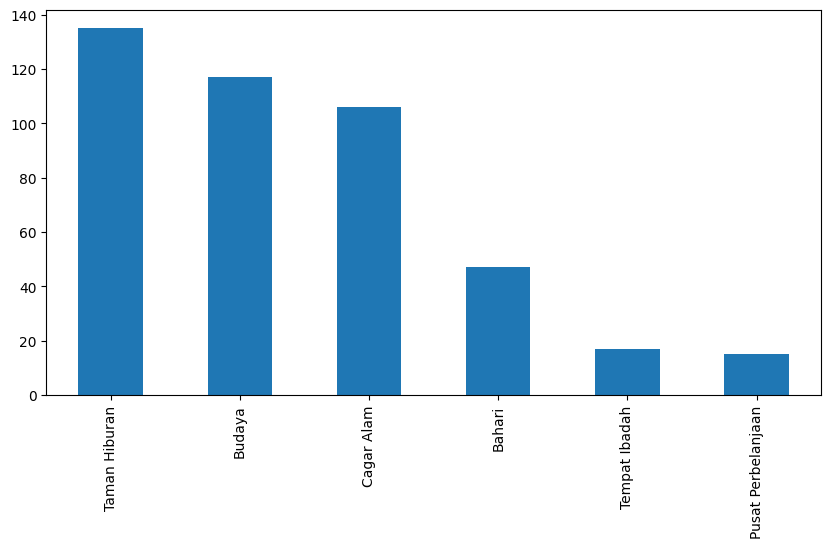

In [ ]:
# Genre distribution
data_filtering['Category'].value_counts().plot(x = 'Category', y ='count', kind = 'bar', figsize = (10,5))
     

<Axes: title={'center': 'Trigram disribution top 20 words Place Name'}, xlabel='trigram'>

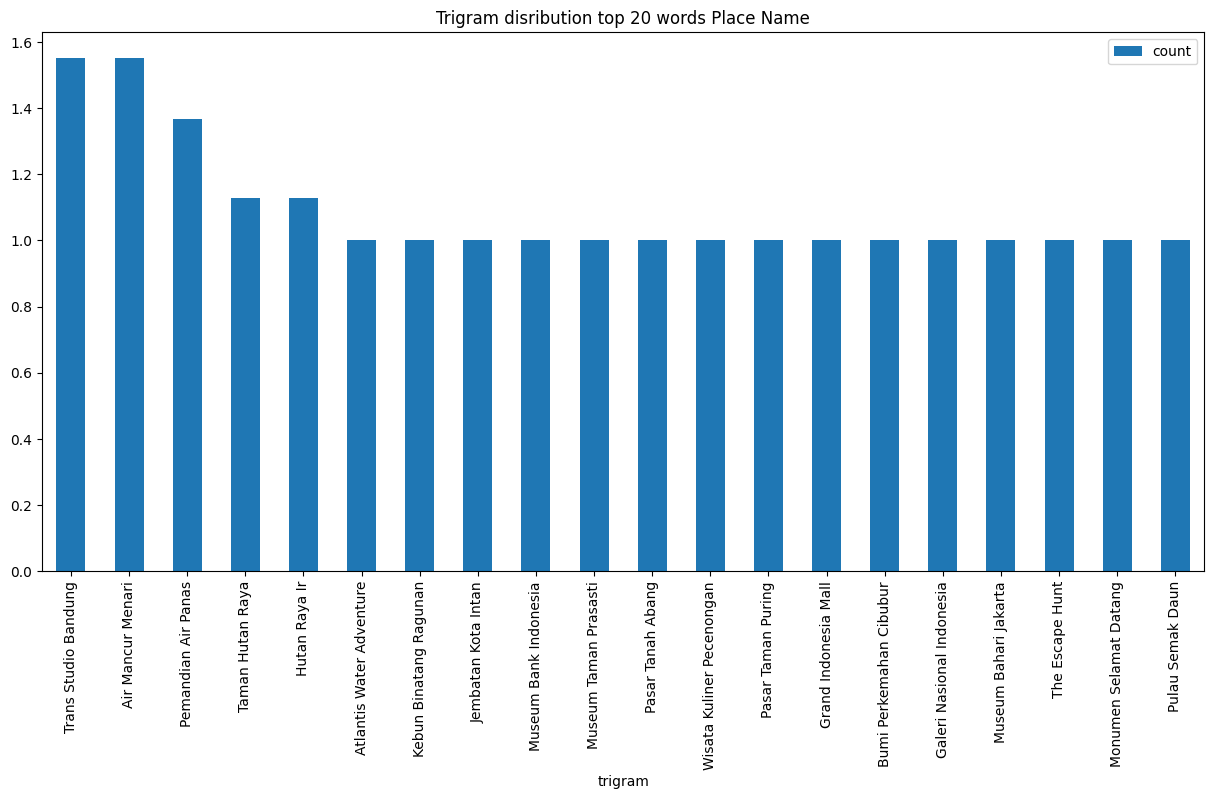

In [ ]:

#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(data_filtering['Place_Name'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution top 20 words Place Name", figsize = (15,7), )
     

In [ ]:
vectors = tfidf.fit_transform(data_filtering['Content']).toarray()
vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
similarity = cosine_similarity(vectors)
similarity[0][1:10]

array([0.04510993, 0.07188361, 0.02807929, 0.00479488, 0.01497397,
       0.02458836, 0.00394491, 0.01975822, 0.01633207])

In [ ]:
def recommend_filtering(nama_tempat):
    # Get the pairwsie similarity scores of all place name with given place name
    nama_tempat_index = data_filtering[data_filtering['Place_Name']==nama_tempat].index[0]
    distancess = similarity[nama_tempat_index]
    # Sort place based on the similarity scores
    nama_tempat_list = sorted(list(enumerate(distancess)),key=lambda x: x[1],reverse=True)[1:20]
    
    recommended_nama_tempats = []
    for i in nama_tempat_list:
        recommended_nama_tempats.append([data_filtering.iloc[i[0]].Place_Name]+[i[1]])
        # print(nama_tempats.iloc[i[0]].original_title)
        
    return recommended_nama_tempats

In [ ]:
recommend_filtering('Pantai Watu Kodok')

[['Pantai Kukup', 0.5659440531411729],
 ['Pantai Timang', 0.5185433503874808],
 ['Pantai Drini', 0.5034916444153296],
 ['Pantai Ngandong', 0.48939744234953786],
 ['Pantai Sundak', 0.4855410205632306],
 ['Pantai Ngrawe (Mesra)', 0.4655150705971857],
 ['Pantai Sadranan', 0.44906283441167205],
 ['Pantai Jungwok', 0.42546650148837023],
 ['Pantai Cipta', 0.4101023347137378],
 ['Pantai Glagah', 0.3757216172666508],
 ['Pantai Nglambor', 0.36837311443087445],
 ['Pantai Congot', 0.34904230497896804],
 ['Pantai Pok Tunggal', 0.34384697708420525],
 ['Pantai Kesirat', 0.3383368340812807],
 ['Pantai Sedahan', 0.33818120552195013],
 ['Pantai Ancol', 0.3376499329941046],
 ['Pantai Sanglen', 0.33675445374563584],
 ['Pantai Goa Cemara', 0.3341901007750466],
 ['Pantai Indrayanti', 0.334168070919927]]

In [ ]:
# Simpan model ke dalam file
model_file = 'content_based_model.pkl'
with open(model_file, 'wb') as file:
    pickle.dump(similarity, file)